# Jupyter Notebook per costruire un grafico distanza-tempo osservato di eventi sismici noti

### TASK:

Build a time-distance graph from real seismograms and compare the results with theoretical curves.  

### WORKFLOW:

(0) Select a seismic event

(1) Calculate epicentral distance between the selected event and seismic stations used 

(2) Download seismic data

(3) Prepare seismic data

(4) Identify the arrival time of the same siesmic phase (P or S) from recordings of the same seismic event on different seimsic stations 

(5) Build traveltime graph as a function of the epicentral distance 

### Import libraries

In [10]:
# To handle file 
import os

# To make calculations
import numpy as np 

# To plot the results
import matplotlib
import matplotlib.pyplot as plt

# To analys seismic data (download included)
import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from obspy.taup import plot_travel_times

# To interact with the Notebook
from ipywidgets import interact, Layout
import ipywidgets as widgets

# To visualise images
from IPython.display import Image
import matplotlib.image as image 



### Define seismic events

Where to find other earthquakes:

https://www.emsc-csem.org/Earthquake/?filter=yes

In [11]:
#
#Seismic event
# Select seismic event by changing EV_ID
EV_ID=1                                       # 1- Tohoku eq. 2- Sumatra eq.  3- Norcia eq

if EV_ID == 1:
    EVENT_NAME="2011_03_11_Japan_Mw9.0"       # LABEL for files
    event_OT="2011-03-11T05:46:24.000"        # Earthquake origin time
    event_lon=142.373                         # E- positive ; W- negative
    event_lat=38.297                          # N- positive; S- negative 
    event_depth=29.0                          #
    event_stat_plot="img/event_1.jpg"         # Map of stations and event
    NAME_and_COORD_stations="input/stations.dat" # File with stations info
    
if EV_ID == 2:
    EVENT_NAME="2004_12_26_Sumatra_Mw9.3"     # LABEL for files
    event_OT="2004-12-26T00:58:50.700"        # Earthquake origin time
    event_lon=95.72                           # E- positive ; W- negative
    event_lat=3.50                            # N- positive; S- negative 
    event_depth=10.0                          #
    event_stat_plot="img/event_2.jpg"         # Map of stations and event
    NAME_and_COORD_stations="input/stations.dat" # File contenente le informazioni sulle stazioni sismiche utilizzate
    
if EV_ID == 3:
    EVENT_NAME="2016_10_30_Norcia_Mw6.5"      # LABEL for files
    event_OT="2016-10-30T06:40:18.300"        # Earthquake origin time
    event_lon=13.11                           # E- positive ; W- negative
    event_lat=42.84                           # N- positive; S- negative 
    event_depth=10.0                          #
    event_stat_plot="img/event_3.jpg"         # Map of stations and event
    NAME_and_COORD_stations="input/stations.dat" # File with stations info
    
if EV_ID == 4:
    EVENT_NAME="2009_04_06_Aquila_Mw6.3"      # LABEL for files
    event_OT="2009-04-06T01:32:41.400"        # Earthquake origin time
    event_lon=13.32                           # E- positive ; W- negative
    event_lat=42.38                           # N- positive; S- negative 
    event_depth=2.0                           #
    event_stat_plot="img/event_3.jpg"         # Map of stations and event
    NAME_and_COORD_stations="input/stations_4.dat" # File with stations info
    
# Seismic stations
NET_CODE="IU"                                 # Name of network (can be found in http://www.fdsn.org/networks/)



## (1) Calculate epicentral distance (degrees) between stations and event

In [12]:
STAT = []
stla = []
stlo = []
dist = []
index_dist_sorted = []

statfile = open(NAME_and_COORD_stations, 'r')
linestoken=statfile.readlines()
istat=0
for x in linestoken:

    STAT.append(x.split()[0])
    stla.append(x.split()[1])
    stlo.append(x.split()[2])

    if istat > 0:       
        stat0=STAT[istat]
        stla0=float(stla[istat])
        stlo0=float(stlo[istat])
        # taup tools from obspy very useful. Here it's used to calculate epicentral distance
        dist0=int(obspy.taup.taup_geo.calc_dist(event_lat,event_lon,stla0,stlo0,6371.0,0.0)) 
        dist.append(dist0)

    istat += 1

    
index_dist_sorted = np.argsort(dist)
Nstat=istat-1 
print('Found:',Nstat,'seismic stations in file:',NAME_and_COORD_stations) 
istat=0
while istat < Nstat:
    stat0=STAT[index_dist_sorted[istat]+1]
    dist0=dist[index_dist_sorted[istat]]
    print('%6s%6s%14s%4d%20s%12.2f%3s' % ('STAT:',stat0,'at distance:',dist0,'in degrees [in km:',dist0*111.19,']'))
    istat += 1


Found: 50 seismic stations in file: input/stations.dat
 STAT:  MAJO  at distance:   3  in degrees [in km:      333.57  ]
 STAT:   YSS  at distance:   8  in degrees [in km:      889.52  ]
 STAT:  INCN  at distance:  12  in degrees [in km:     1334.28  ]
 STAT:   PET  at distance:  18  in degrees [in km:     2001.42  ]
 STAT:  TATO  at distance:  22  in degrees [in km:     2446.18  ]
 STAT:  GUMO  at distance:  24  in degrees [in km:     2668.56  ]
 STAT:   YAK  at distance:  24  in degrees [in km:     2668.56  ]
 STAT:   ULN  at distance:  27  in degrees [in km:     3002.13  ]
 STAT:  WAKE  at distance:  28  in degrees [in km:     3113.32  ]
 STAT:  BILL  at distance:  32  in degrees [in km:     3558.08  ]
 STAT:  MIDW  at distance:  34  in degrees [in km:     3780.46  ]
 STAT:   DAV  at distance:  34  in degrees [in km:     3780.46  ]
 STAT:  TIXI  at distance:  34  in degrees [in km:     3780.46  ]
 STAT:  CHTO  at distance:  42  in degrees [in km:     4669.98  ]
 STAT:  COLA  at dist

### Mappa delle stazioni sismiche selezionate e dell evento

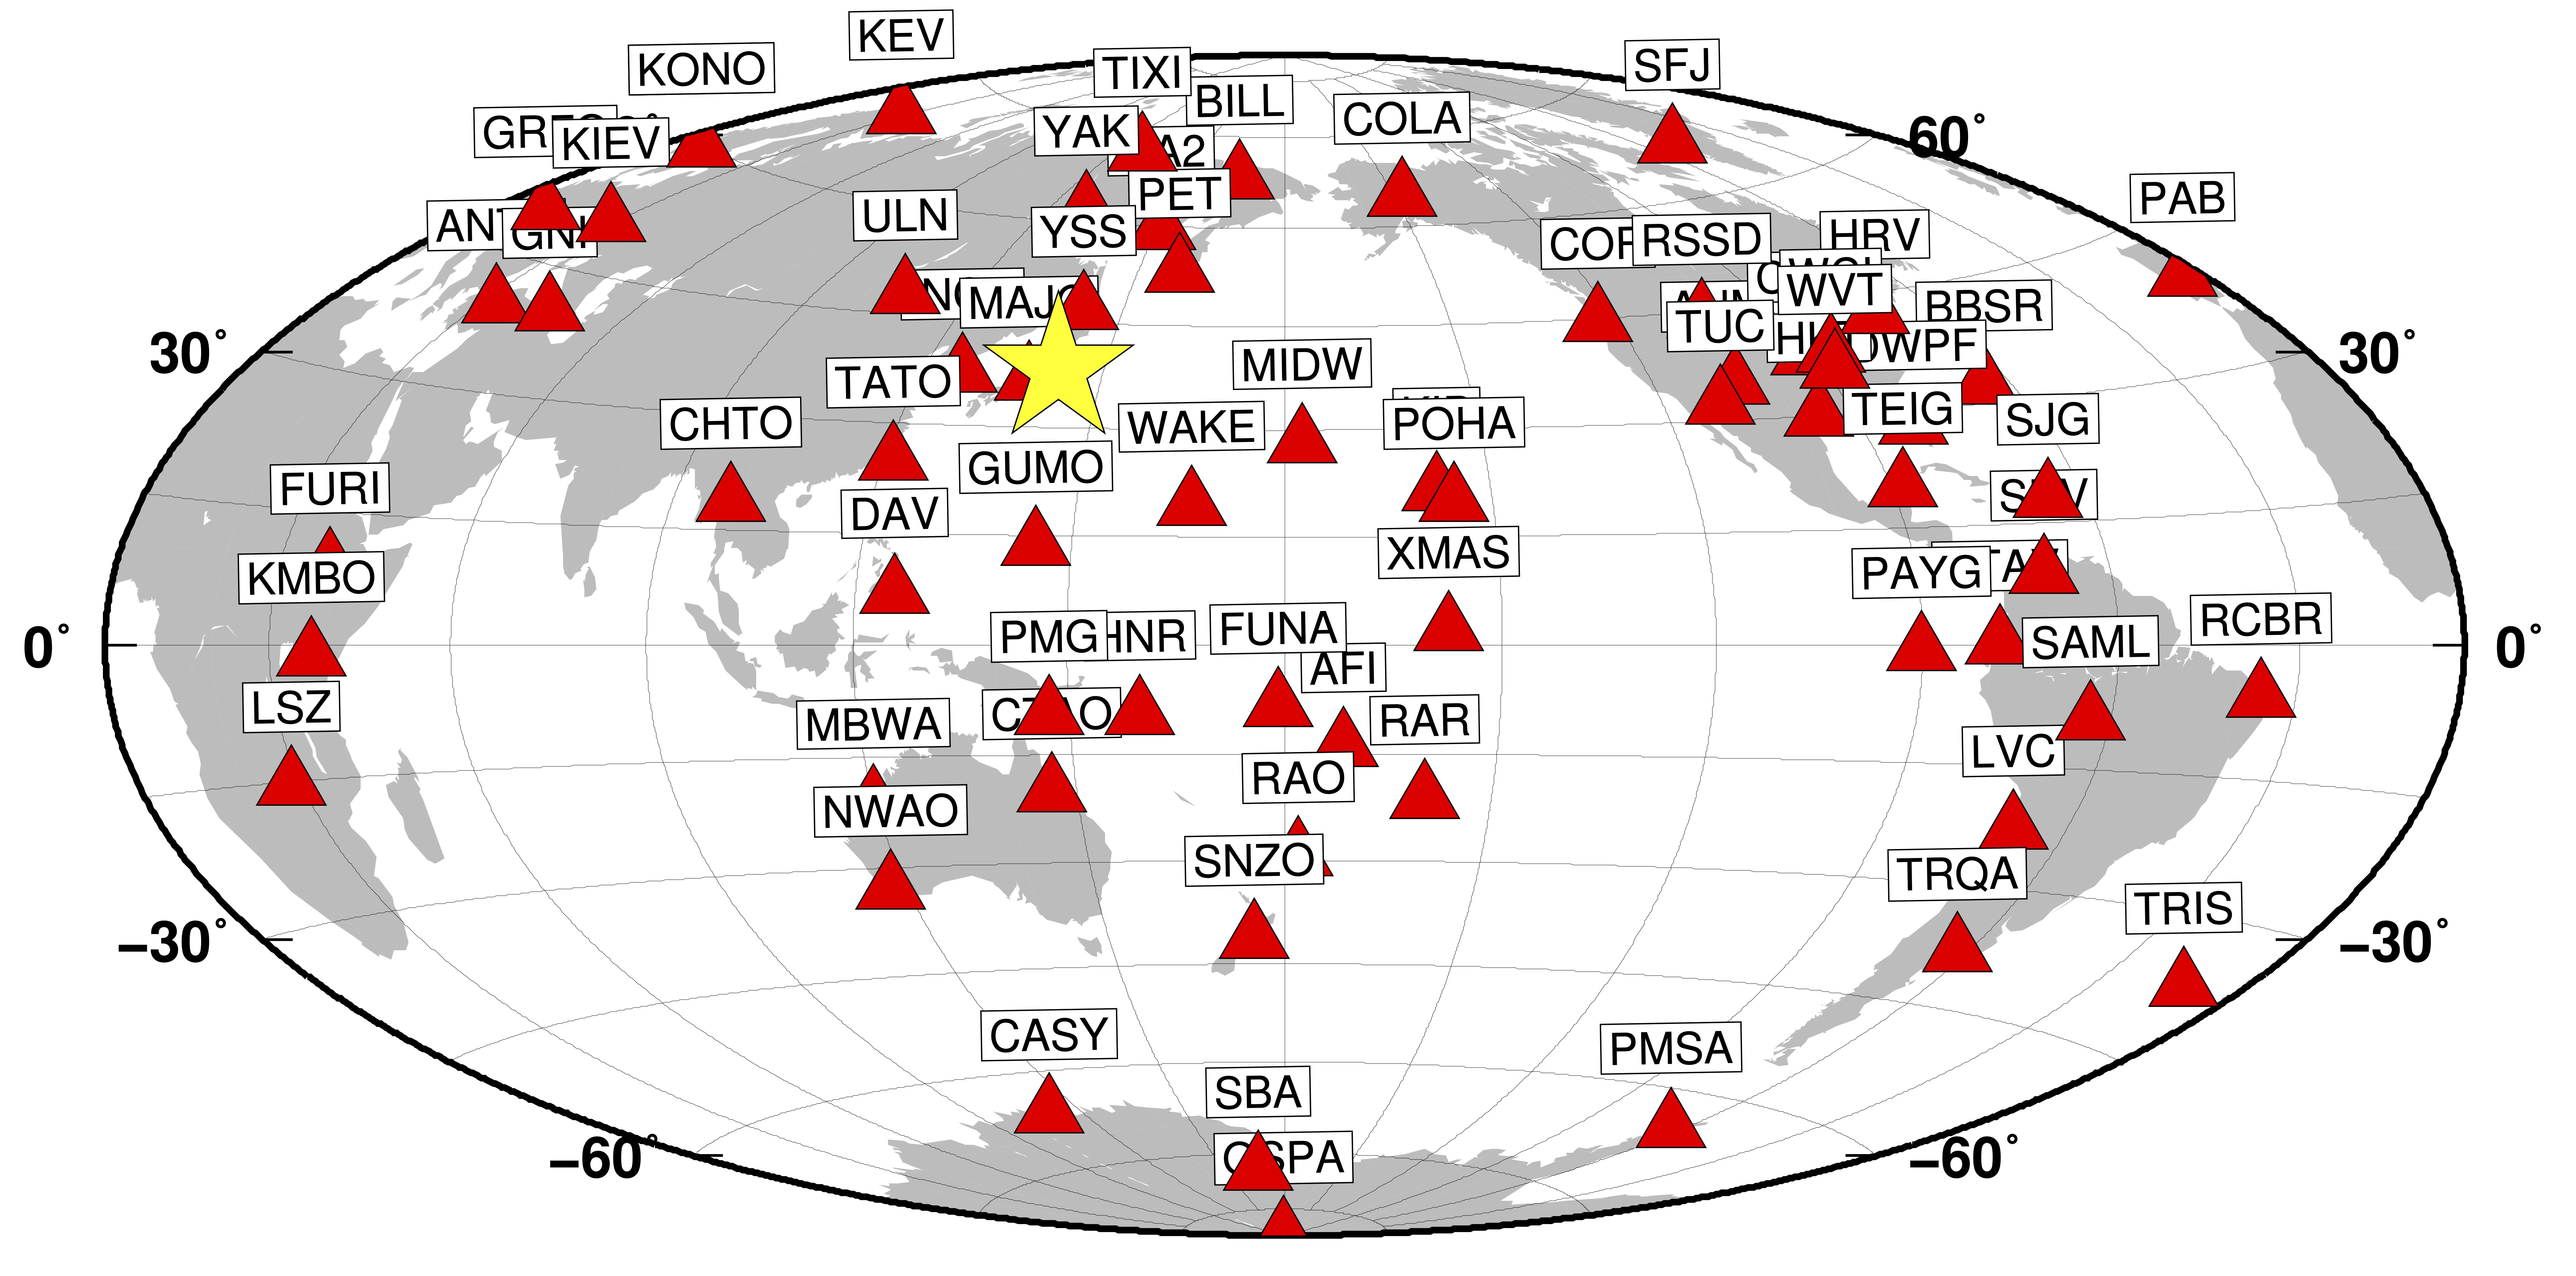

In [13]:
Image(event_stat_plot,width=8000)

## (2) Read (or download) seismic data for selected stations

IU.MAJO.00.BHZ | 2011-03-11T05:46:24.019538Z - 2011-03-11T06:46:23.969538Z | 20.0 Hz, 72000 samples
IU.YSS.00.BHZ | 2011-03-11T05:46:24.010645Z - 2011-03-11T06:46:23.960645Z | 20.0 Hz, 72000 samples
IU.INCN.00.BHZ | 2011-03-11T05:46:24.019538Z - 2011-03-11T06:46:23.969538Z | 20.0 Hz, 72000 samples
IU.PET.00.BHZ | 2011-03-11T05:46:24.010645Z - 2011-03-11T06:46:23.960645Z | 20.0 Hz, 72000 samples
IU.TATO.00.BHZ | 2011-03-11T05:46:24.019538Z - 2011-03-11T06:46:23.969538Z | 20.0 Hz, 72000 samples
IU.GUMO.00.BHZ | 2011-03-11T05:46:24.019536Z - 2011-03-11T06:46:23.969536Z | 20.0 Hz, 72000 samples
IU.YAK.00.BHZ | 2011-03-11T05:46:24.047364Z - 2011-03-11T06:46:23.997364Z | 20.0 Hz, 72000 samples
IU.ULN.00.BHZ | 2011-03-11T05:46:24.035664Z - 2011-03-11T06:46:23.985664Z | 20.0 Hz, 72000 samples
IU.WAKE.00.BHZ | 2011-03-11T05:46:24.019538Z - 2011-03-11T06:46:23.969538Z | 20.0 Hz, 72000 samples
IU.BILL.00.BHZ | 2011-03-11T05:46:24.048363Z - 2011-03-11T06:46:23.998363Z | 20.0 Hz, 72000 samples
IU.T

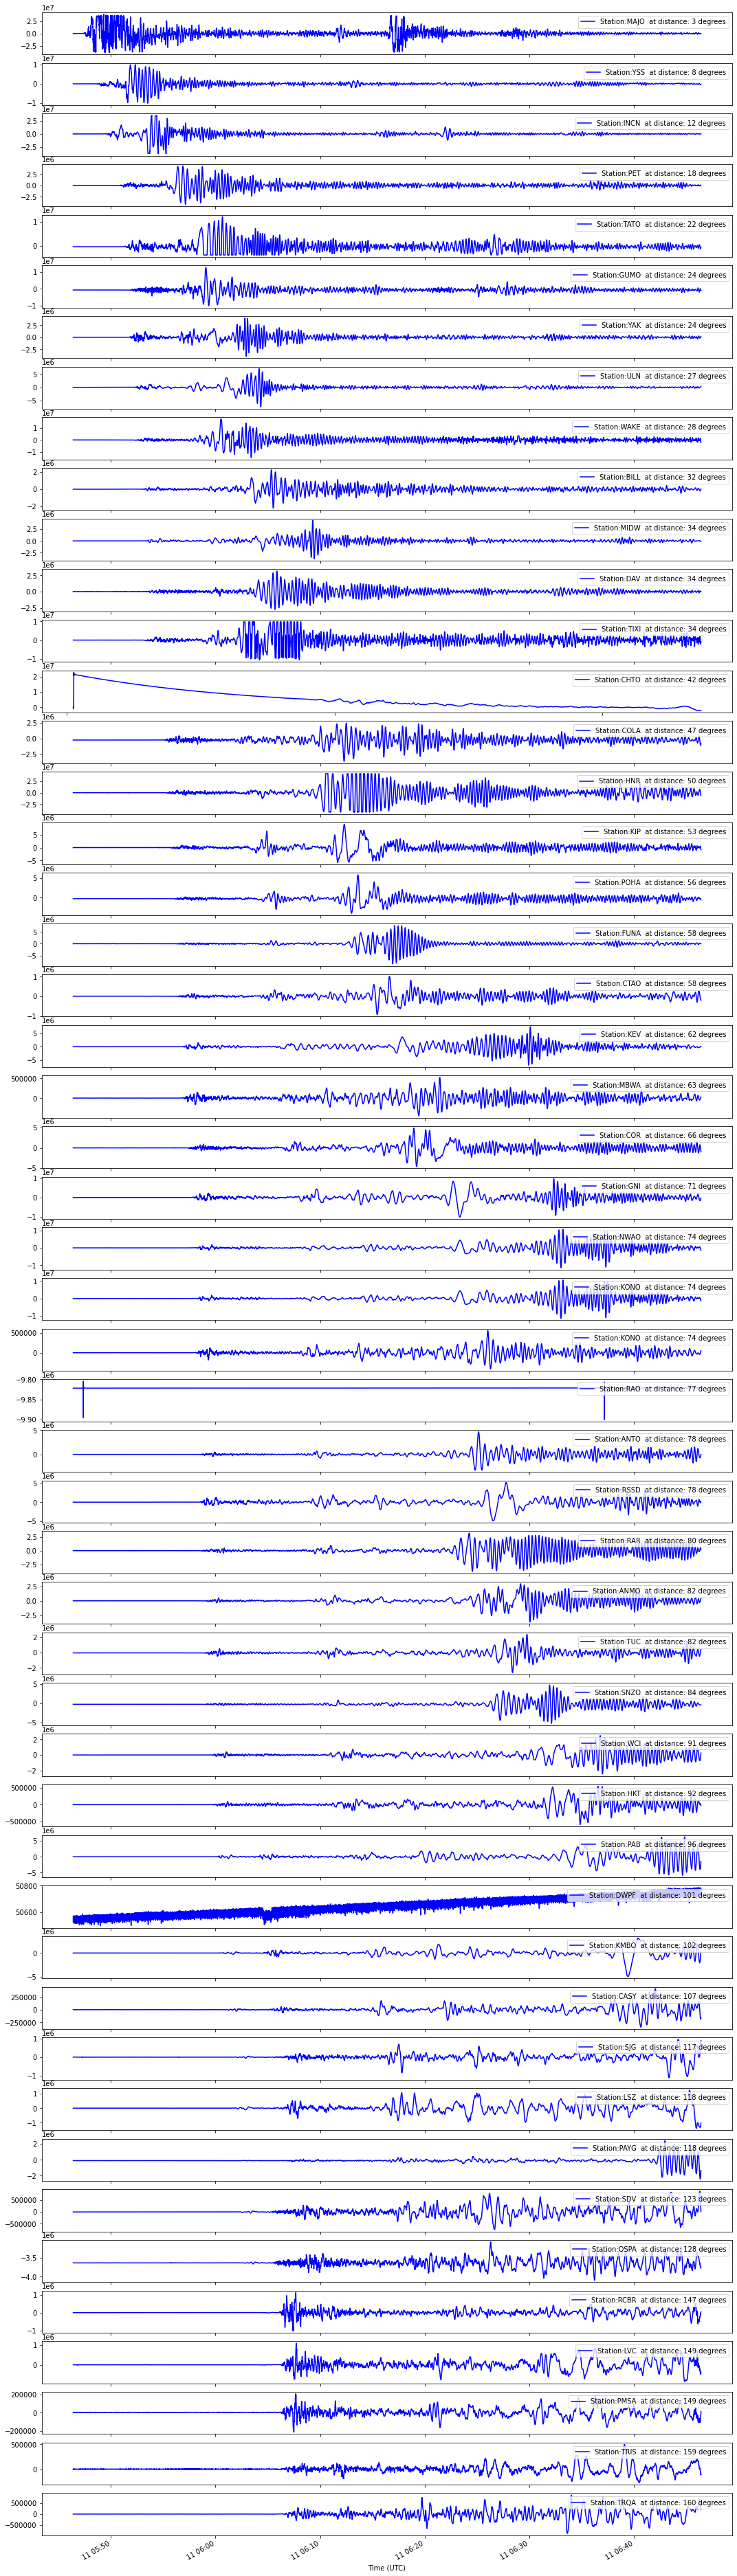

In [15]:
#
# Define how to get the data: download from web or read from file  
READ_FROM = 'FILE'                         # WEB o FILE  -- 'WEB', direct download; 'FILE', lread from file
#
#
#
#
# Section to download data from WEB  --- Currently not used to save time during lecture
#
if READ_FROM == 'WEB':
#
#
#

    client = Client("IRIS")
    t = UTCDateTime(event_OT)

    istat=1
    while istat <= Nstat:
        stat0=STAT[index_dist_sorted[istat-1]+1]
        print('Downloading data for station:', stat0, ' ... ', istat)
        st = client.get_waveforms(NET_CODE, stat0, "00", "BHZ", t, t + 60 * 60)
        if istat == 1:
            tr=st.copy()
        else:
            tr.append(st[0])

        istat += 1


    #Salvare i dati in formato MSEED
    file_path = './data/' + EVENT_NAME + '.mseed'
    tr.write(file_path, format='MSEED') 


    

#
# Section to locally read data from files 
#
if READ_FROM == 'FILE':
#
#
    file_path = './data/' + EVENT_NAME + '.mseed'
    tr=obspy.read(file_path, format='MSEED')
#

#
# Check seismic data

fig_size=1.5*Nstat
fig = plt.figure(figsize=(18, fig_size))

istat=1
while istat <= Nstat:
    print(tr[istat-1])
    tr0 = tr[istat-1]
    stat0=STAT[index_dist_sorted[istat-1]+1]
    dist0=str(int(dist[index_dist_sorted[istat-1]]))
    label0= 'Station:' + stat0 + '  at distance: ' + dist0 +' degrees'
    ax = fig.add_subplot(Nstat, 1, istat)
    ax.plot(tr0.times("matplotlib"), tr0.data, "b-", label=label0)
    plt.legend(loc='upper right')
    ax.xaxis_date()
    fig.autofmt_xdate()
    istat += 1

plt.xlabel('Time (UTC)')    
plt.show()


## (3) Identify the arrival time of the same seismic phase (P or S) from recordings of the same seismic event on different seismic stations


In [16]:
file_path = './output/' + EVENT_NAME + '.picking'

if os.path.exists(file_path):
    print('File: ', file_path, 'exists. New data will be appended')
else:
    pick_file=open(file_path,'w')
    pick_file.close


tr0 = []
t = []
t=np.arange(0,3600,1.0/20.0)


IN_STAT=input('Seleziona una stazione [1-50]:')
istat=int(IN_STAT)

tr0 = tr[istat-1]
stat0=STAT[index_dist_sorted[istat-1]+1]
dist0=dist[index_dist_sorted[istat-1]]
amp=tr0.data

dist1=int(dist0)
print('Stazione selezionata:', stat0, 'a distanza: ',dist1)

    
@interact(Pwave=widgets.FloatSlider(min=0.01, max=3600, step=1, value=100,
                                        continuous_update=False, layout=Layout(width='90%', height='30px')), 
          Swave=widgets.FloatSlider(min=0.01, max=3600, step=1, value=200,
                                        continuous_update=False, layout=Layout(width='90%', height='30px')),
          X=widgets.FloatRangeSlider(value=[0, 3600], min=0,max=3600.0, step=1, description='ZOOM',
                                        continuous_update=False, layout=Layout(width='90%', height='30px')),
          Save=False)
    
def npa_picking(Pwave, Swave, X, Save):
    
    x_0=int(X[0])*20
    x_1=int(X[1])*20
    t_plot = []
    tr0_plot = []
    t_plot = t[x_0:x_1]
    tr0_plot=tr0[x_0:x_1]

    plt.figure(figsize=(18,3))
    plt.plot(t_plot,tr0_plot)
    plt.grid()
    plt.ylabel('Amplitude')
    plt.xlabel('Time from OT (s)')
    plt.title('Seismic station:' + stat0)
    plt.xlim(X[0],X[1])
    plt.axvline(x=Pwave, ymin=0.10, ymax=0.90,linewidth=4, color='r')
    plt.axvline(x=Swave, ymin=0.10, ymax=0.90,linewidth=4, color='b')
    print('Seismic station:', stat0, 'P/S arrival times:',Pwave,Swave)
    if Save == True:
        Pwave_minutes=Pwave/60
        Swave_minutes=Swave/60
        print('\nWriting selected P-wave and S-wave picks for station: ' + stat0)
        pick_file=open(file_path,'a')
        pick_file.write('%16.4f%20.4f%16.4f%6s\n' % (dist0,Pwave_minutes,Swave_minutes,stat0))  
        pick_file.close
    plt.figure()
    

Seleziona una stazione [1-50]:4
Stazione selezionata: PET a distanza:  18


interactive(children=(FloatSlider(value=100.0, continuous_update=False, description='Pwave', layout=Layout(hei…

## Build traveltime graph as a function of the epicentral distance

Found: 2  results


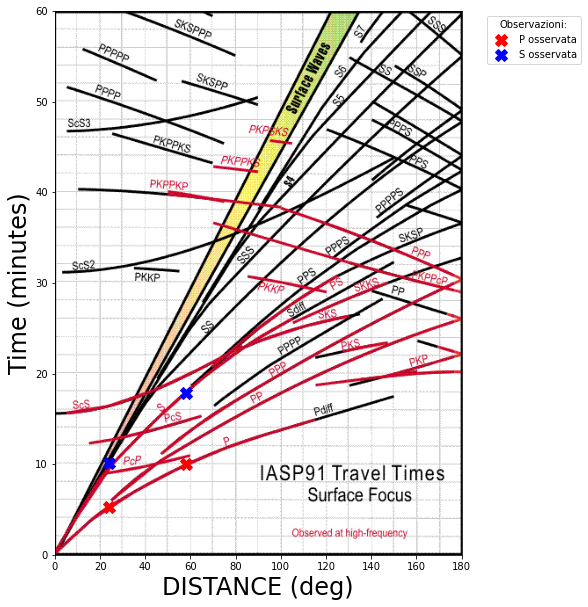

In [9]:
file_path = './output/' + EVENT_NAME + '.picking'

DIST = []
P_data = []
S_data = []

# Read results
resultfile = open(file_path, 'r')
linestoken=resultfile.readlines()
i=1
for x in linestoken:

    dist_new=float(x.split()[0])
    DIST.append(dist_new)
    p=float(x.split()[1])
    P_data.append(p)
    s=float(x.split()[2])
    S_data.append(s)
    
    i += 1


print('Found:', i-1, ' results')


im = plt.imread("img/tempi_teorici.jpg")
plt.figure(figsize=(8,10))
xmin, xmax, ymin, ymax = (0, 180, 0, 60)
aspect = im.shape[0] / im.shape[1] * (xmax - xmin)/(ymax - ymin)
plt.imshow(im, zorder=0, extent=[xmin, xmax, ymin, ymax], aspect=aspect)
plt.xlim(0,180)
plt.ylim(0,60)
plt.plot(DIST, P_data, 'X', markersize=12, color='red',label="P osservata")
plt.plot(DIST, S_data, 'X', markersize=12, color='blue',label="S osservata")
plt.legend(title='Observazioni:', bbox_to_anchor=(1.05, 1), loc='upper left',)
plt.xlabel("DISTANCE (deg)", fontsize=24)
plt.ylabel("Time (minutes)",fontsize=24)
plt.show()
